# Import libraries

In [261]:
import os

import numpy as np
import pandas as pd


# Read data

In [262]:
DATASET_PATH = '../../data/processed/HAR'
DATASET_CSV_PATH = f'{DATASET_PATH}/UCF'

In [263]:
LABEL = {
    'Jump': 0,
    'Kick': 1,
    'Punch': 2,
    'Left': 3,
    'Right': 4,
    'Stand': 5
}

In [264]:
X = []
y = []

# Read all files in the dataset
for label in LABEL:
    for file in os.listdir(f'{DATASET_CSV_PATH}/Train/{label}'):
        df = pd.read_csv(f'{DATASET_CSV_PATH}/Train/{label}/{file}', sep=',')
        X.append(df)
        y.append(LABEL[label])

In [265]:
# Drop frame_num and timestamp columns
for i, element in enumerate(X):
    if 'frame_num' and 'timestamp' in element.columns:
        X[i] = element.drop(columns=['frame_num', 'timestamp'])


In [266]:
for i, element in enumerate(X):
    for column in element.columns:
        X[i][column] = X[i][column].apply(lambda x: np.array(x[1:-1].split(',')).astype(np.float32))

## Convert All Sequences to the Same Length

In [267]:
# Get the maximum length of all sequences
all_dim = []
for i, element in enumerate(X):
    all_dim.append(element.shape[0])
    # print(f"Element {i} shape: {np.shape(element)}, label: {y[i]}")

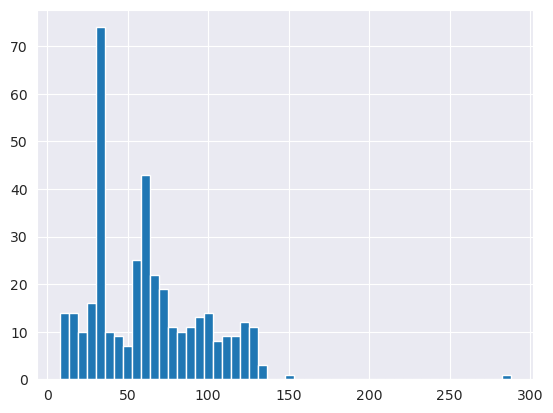

In [268]:
# Visualize the distribution of the lengths of all sequences
import matplotlib.pyplot as plt

plt.hist(all_dim, bins=50)
plt.show()

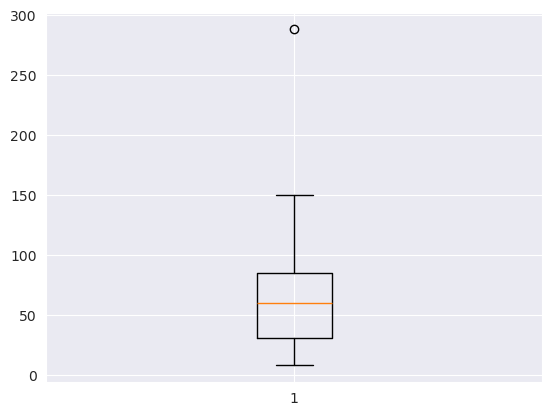

In [269]:
# Visualize the boxplot of the lengths of all sequences
plt.boxplot(all_dim)
plt.show()

### Handle the Outliers and make the lengths of all sequences the same
Handle different lengths of sequences
    Set the maximum length = 1.5 * IQR + Q3
    
    * Case 1: If e_dim < Max_dim, then increase the length of the sequence by duplicating each row until the length of the sequence is equal to Max_dim
    * Case 2: If e_dim > Max_dim, then truncate randomly the sequence until the length of the sequence is equal to Max_dim
    * Case 3: If e_dim = Max_dim, then keep the sequence as it is

In [270]:
# Convert all sequences to the same length
Q1 = np.percentile(all_dim, 25)
Q3 = np.percentile(all_dim, 75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print(f"Q1: {Q1}, Q3: {Q3}, IQR: {IQR}, Lower bound: {lower_bound}, Upper bound: {upper_bound}")

Q1: 31.0, Q3: 85.25, IQR: 54.25, Lower bound: -50.375, Upper bound: 166.625


In [271]:
# # Drop outliers
# for i, element in enumerate(X):
#     if element.shape[0] < lower_bound or element.shape[0] + 1 > upper_bound:
#         X.pop(i)
#         y.pop(i)

In [272]:
Max_dim = 35

In [273]:
X[0].shape

(60, 33)

In [274]:
test = X[0]
test.shape

(60, 33)

In [275]:
test_np = np.array(test)

In [276]:
test_np[0]

array([array([ 0.32287672,  0.21202336, -0.67587554], dtype=float32),
       array([ 0.33489576,  0.20126103, -0.634141  ], dtype=float32),
       array([ 0.34347016,  0.2027628 , -0.63427764], dtype=float32),
       array([ 0.35302362,  0.20438325, -0.63434863], dtype=float32),
       array([ 0.3167012 ,  0.20125826, -0.63633627], dtype=float32),
       array([ 0.3096566 ,  0.20267048, -0.6363791 ], dtype=float32),
       array([ 0.30156323,  0.2040832 , -0.6365455 ], dtype=float32),
       array([ 0.36562806,  0.21975935, -0.40430787], dtype=float32),
       array([ 0.29237404,  0.21917868, -0.4152649 ], dtype=float32),
       array([ 0.33645055,  0.23478696, -0.59057593], dtype=float32),
       array([ 0.3142371 ,  0.23422724, -0.59419036], dtype=float32),
       array([ 0.42068452,  0.33753106, -0.2846459 ], dtype=float32),
       array([ 0.221617  ,  0.3467121 , -0.22916293], dtype=float32),
       array([ 0.4614378 ,  0.46082032, -0.19673002], dtype=float32),
       array([ 0.190

In [277]:
X_train_temp = []
Y_train_temp = []


def pad_length(ele, max_dim, metric_temp: list = None) -> np.array:
    if metric_temp is None:
        metric_temp = []
    if ele.shape[0] == max_dim:
        return ele

    step = max(1, ele.shape[0] // (max_dim - ele.shape[0]))

    for j in range(0, ele.shape[0]):
        metric_temp.append(ele[j])
        if len(metric_temp) == max_dim:
            break
        if j % step == 0:
            metric_temp.append(ele[j])
        if len(metric_temp) == max_dim:
            break
    return pad_length(np.array(metric_temp), max_dim)


def truncate_length(ele, max_dim, start=0) -> np.array:
    if ele.shape[0] == max_dim:
        return pd.DataFrame(ele)

    metrics_temp = []
    step = max(2, ele.shape[0] // (ele.shape[0] - max_dim))
    j = start
    while len(metrics_temp) != max_dim:
        metrics_temp.append(ele[j])
        j = (j + step) % ele.shape[0]
    return np.array(metrics_temp)


def pad_and_truncate(ele, max_dim: int = 35) -> np.array:
    list_elements = []
    current_length = ele.shape[0]

    if current_length == max_dim:
        return [ele]

    dev = max(int(round(current_length / max_dim)), 1)
    if dev * max_dim > current_length:
        new_element = pad_length(ele, max_dim * dev)

        if new_element.shape[0] > max_dim:
            for step in range(dev):
                list_elements.append(truncate_length(new_element, max_dim, step))
        else:
            list_elements.append(new_element)
    else:
        for step in range(dev):
            list_elements.append(truncate_length(ele, max_dim, step))
    return list_elements


# Pad all sequences to the same length
for i, element in enumerate(X):
    print(f"Before padding, element {i} shape: {np.shape(element)}")
    padded_element = pad_and_truncate(np.array(element), Max_dim)
    print(f"After padding, element {i} shape: {np.shape(padded_element)}")
    X_train_temp = X_train_temp + padded_element
    Y_train_temp = Y_train_temp + [y[i]] * len(padded_element)
    print('y[i]: ', y[i])
    print(f'padded_element: {np.shape(padded_element)}')
    print(f"After padding X_train_temp, element {i} shape: {np.shape(X_train_temp)}")
    print(f"After padding Y_train_temp, element {i} shape: {np.shape(Y_train_temp)}")
    print('-----------------------------------')
# test = X[15]
# padded_element = pad_and_truncate(test, Max_dim)
# np.array(padded_element).shape

Before padding, element 0 shape: (60, 33)
After padding, element 0 shape: (2, 35, 33)
y[i]:  0
padded_element: (2, 35, 33)
After padding X_train_temp, element 0 shape: (2, 35, 33)
After padding Y_train_temp, element 0 shape: (2,)
-----------------------------------
Before padding, element 1 shape: (13, 33)
After padding, element 1 shape: (1, 35, 33)
y[i]:  0
padded_element: (1, 35, 33)
After padding X_train_temp, element 1 shape: (3, 35, 33)
After padding Y_train_temp, element 1 shape: (3,)
-----------------------------------
Before padding, element 2 shape: (31, 33)
After padding, element 2 shape: (1, 35, 33)
y[i]:  0
padded_element: (1, 35, 33)
After padding X_train_temp, element 2 shape: (4, 35, 33)
After padding Y_train_temp, element 2 shape: (4,)
-----------------------------------
Before padding, element 3 shape: (67, 33)
After padding, element 3 shape: (2, 35, 33)
y[i]:  0
padded_element: (2, 35, 33)
After padding X_train_temp, element 3 shape: (6, 35, 33)
After padding Y_train_

In [278]:
X_train_ = np.array(X_train_temp)

In [279]:
X_train_temp

[array([[array([ 0.32287672,  0.21202336, -0.67587554], dtype=float32),
         array([ 0.33489576,  0.20126103, -0.634141  ], dtype=float32),
         array([ 0.34347016,  0.2027628 , -0.63427764], dtype=float32),
         ..., array([0.28324357, 0.92395306, 0.22448903], dtype=float32),
         array([0.3716547 , 0.94183046, 0.13043672], dtype=float32),
         array([0.21524484, 0.945434  , 0.00215097], dtype=float32)],
        [array([ 0.32353625,  0.2289574 , -0.7461532 ], dtype=float32),
         array([ 0.33824226,  0.21607211, -0.70896953], dtype=float32),
         array([ 0.34767166,  0.21807882, -0.70893276], dtype=float32),
         ..., array([0.28403518, 0.92224526, 0.5293127 ], dtype=float32),
         array([0.3884092, 0.9463611, 0.3692768], dtype=float32),
         array([0.20860195, 0.942839  , 0.25647575], dtype=float32)],
        [array([ 0.32385206,  0.22665517, -0.6455869 ], dtype=float32),
         array([ 0.34069994,  0.21895063, -0.6055088 ], dtype=float32),
 

In [280]:
X_train = np.full((X_train_.shape[0], X_train_.shape[1], X_train_.shape[2], 3), np.nan, dtype=np.float32)

for i, element in enumerate(X_train_):
    for j, row in enumerate(element):
        for k, value in enumerate(row):
            # Check if the value is np.array([nan, nan, nan])
            if np.isnan(value).all():
                X_train_[i][j][k] = np.array([np.nan, np.nan, np.nan], dtype=np.float32)
            else:
                X_train_[i][j][k] = value

            X_train[i][j][k] = X_train_[i][j][k][:3]

In [281]:
X_train.shape

(718, 35, 33, 3)

## Handle Fill NaN Values

### Step 1: Compute the variance of each metric for each sequence.

### Step 2: Fill NaN
   * **Case 1**: If `element[i]` doesn't have a value before, then get the value from the nearest posterior element, and adjust by adding or subtracting the variance of the metric.
   * **Case 2**: If `element[i]` doesn't have a value after, then get the value from the nearest previous element, and adjust by adding or subtracting the variance of the metric.
   * **Case 3**: If `element[i]` has values both before and after, then use the nearest previous and posterior elements:
     - For \( k < i < l \):

$$
\text{element}[i] = \text{element}[k] + (\text{element}[l] - \text{element}[k]) \times \frac{i - k}{l - k}
$$


### Step 1: Compute the variance of each metric for each sequence.

In [282]:
X_train.shape

(718, 35, 33, 3)

In [283]:
cnt = 0

In [284]:
np.nanvar(X_train[0][:, 0], axis=0)

array([1.5271826e-05, 2.0467925e-03, 6.2849610e-03], dtype=float32)

In [285]:
variance_metric = np.empty((X_train.shape[0], X_train.shape[2], 3), dtype=np.float32)
variance_metric.shape

(718, 33, 3)

In [286]:
X_train[0][:, 0].shape

(35, 3)

In [287]:
np.nanvar(X_train[1][:, 0], axis=0)

array([1.5780812e-05, 2.0047883e-03, 6.5007866e-03], dtype=float32)

In [288]:
cls_nan = dict()

for i, element in enumerate(X_train):
    sub_variance_metric = np.empty((element.shape[1], 3), dtype=np.float32)

    for j in range(element.shape[1]):
        variance = np.array([np.nan, np.nan, np.nan], dtype=np.float32)

        # If there are more than 1 non-NaN values, calculate variance
        if np.count_nonzero(~np.isnan(element[:, j])) > 1:
            variance = np.nanvar(element[:, j], axis=0)
            print(variance)
        else:
            if i not in cls_nan:
                cls_nan[i] = []
            cls_nan[i].append(j)
        # convert to list
        sub_variance_metric[j] = variance
    # print(sub_variance_metric)
    variance_metric[i] = sub_variance_metric

[1.5271826e-05 2.0467925e-03 6.2849610e-03]
[1.7878367e-05 2.1600334e-03 6.4886492e-03]
[2.0784768e-05 2.1587517e-03 6.4835278e-03]
[2.3506920e-05 2.1582665e-03 6.4806612e-03]
[1.5447087e-05 2.1547081e-03 6.3725025e-03]
[1.7197355e-05 2.1594816e-03 6.3760462e-03]
[1.7824799e-05 2.1611487e-03 6.3766879e-03]
[3.3325799e-05 2.2089765e-03 6.4768866e-03]
[3.0099796e-05 2.2453426e-03 5.8840257e-03]
[2.3648086e-05 2.0144458e-03 6.2092911e-03]
[2.0116475e-05 2.0149872e-03 6.0374402e-03]
[7.7037927e-05 2.0767064e-03 5.2269469e-03]
[7.8914214e-05 2.3131294e-03 5.0604860e-03]
[6.6422355e-05 2.2431808e-03 5.2870340e-03]
[7.3960487e-05 2.4953482e-03 3.9446643e-03]
[5.0016712e-05 2.3213918e-03 4.7030118e-03]
[0.00012208 0.00276223 0.00548522]
[6.9160997e-05 2.3537402e-03 4.7404557e-03]
[0.00020634 0.002805   0.00605205]
[5.6541470e-05 2.3775662e-03 4.3723388e-03]
[0.00024836 0.00279011 0.00586937]
[4.638471e-05 2.378113e-03 4.432054e-03]
[0.00021452 0.00276889 0.00555016]
[2.7824737e-05 1.9054544e-0

In [289]:
variance_metric = np.array([variance_metric], dtype=np.float32)

In [290]:
variance_metric = variance_metric.reshape(variance_metric.shape[1], variance_metric.shape[2], variance_metric.shape[3])

In [291]:
variance_metric.shape

(718, 33, 3)

In [292]:
# convert to cls_nan to pandas dataframe
cls_nan.keys()

dict_keys([260, 263, 266, 271, 287, 291, 309, 320, 321, 332, 336, 338, 346, 348, 359, 524, 525, 526])

In [293]:
LABEL

{'Jump': 0, 'Kick': 1, 'Punch': 2, 'Left': 3, 'Right': 4, 'Stand': 5}

### Step 2: Fill NaN
   * **Case 1**: If `element[i]` doesn't have a value before, then get the value from the nearest posterior element, and adjust by adding or subtracting the variance of the metric.
   * **Case 2**: If `element[i]` doesn't have a value after, then get the value from the nearest previous element, and adjust by adding or subtracting the variance of the metric.
   * **Case 3**: If `element[i]` has values both before and after, then use the nearest previous and posterior elements:
     - For \( k < i < l \):

$$
\text{element}[i] = \text{element}[k] + (\text{element}[l] - \text{element}[k]) \times \frac{i - k}{l - k}
$$


In [294]:
X_train.shape

(718, 35, 33, 3)

In [295]:
variance_metric.shape

(718, 33, 3)

In [296]:
# Function to fill NaN values based on the described cases
def fill_nan(element, variance_metric):
    old_value = None
    k = 0

    for i in range(element.shape[0]):
        if np.isnan(element[i]).all():
            # Case 1: If element[i] doesn't have a value before, then get the value from the nearest posterior element, and adjust by adding or subtracting the variance of the metric.
            if old_value is None:
                for l in range(i + 1, element.shape[0]):
                    if not np.isnan(element[l]).all():
                        element[i] = element[l] + abs(i - l) * variance_metric
                        break
            else:
                # Case 2: If element[i] doesn't have a value after, then get the value from the nearest previous element, and adjust by adding or subtracting the variance of the metric.
                flat = False
                for l in range(i + 1, element.shape[0]):
                    if not np.isnan(element[l]).all():
                        if l != k:
                            element[i] = old_value + (element[l] - old_value) / ((i - k) / (l - k))
                            flat = True
                            break
                if not flat:
                    # Case 3: If element[i] has values both before and after, then use the nearest previous and posterior elements
                    element[i] = old_value - abs(i - k) * variance_metric
        old_value = element[i]
    return element

In [297]:
X_train_new = np.empty(X_train.shape, dtype=np.float32)
for i in range(X_train.shape[0]):
    for j in range(X_train.shape[2]):
        # print("Shape of element: ", X_train[i][: , j].shape)
        # print("Shape of variance: ", variance_metric[i][j].shape)
        X_train_new[i][:, j] = fill_nan(X_train[i][:, j], variance_metric[i][j])

In [298]:
# Save the processed data
np.save('X_train.npy', X_train_new)
np.save('y_train.npy', Y_train_temp)

In [299]:
import numpy as np

# Load the processed data
X_train = np.load('X_train.npy')
y_train = np.load('y_train.npy')

In [300]:
for i in range(X_train.shape[0]):
    for j in range(X_train.shape[2]):
        if np.isnan(X_train[i][:, j]).sum() > 0:
            print(f"Element {i}, Metric {j}, NaN: {np.isnan(X_train[i][:, j]).sum()}")

Element 260, Metric 0, NaN: 105
Element 260, Metric 1, NaN: 105
Element 260, Metric 2, NaN: 105
Element 260, Metric 3, NaN: 105
Element 260, Metric 4, NaN: 105
Element 260, Metric 5, NaN: 105
Element 260, Metric 6, NaN: 105
Element 260, Metric 7, NaN: 105
Element 260, Metric 8, NaN: 105
Element 260, Metric 9, NaN: 105
Element 260, Metric 10, NaN: 105
Element 260, Metric 11, NaN: 105
Element 260, Metric 12, NaN: 105
Element 260, Metric 13, NaN: 105
Element 260, Metric 14, NaN: 105
Element 260, Metric 15, NaN: 105
Element 260, Metric 16, NaN: 105
Element 260, Metric 17, NaN: 105
Element 260, Metric 18, NaN: 105
Element 260, Metric 19, NaN: 105
Element 260, Metric 20, NaN: 105
Element 260, Metric 21, NaN: 105
Element 260, Metric 22, NaN: 105
Element 260, Metric 23, NaN: 105
Element 260, Metric 24, NaN: 105
Element 260, Metric 25, NaN: 105
Element 260, Metric 26, NaN: 105
Element 260, Metric 27, NaN: 105
Element 260, Metric 28, NaN: 105
Element 260, Metric 29, NaN: 105
Element 260, Metric 

In [301]:
# Drop the NaN values
X_new_train = []
y_new_train = []
for i in range(X_train.shape[0]):
    if np.isnan(X_train[i]).sum() == 0:
        X_new_train.append(X_train[i])
        y_new_train.append(y_train[i])

X_new_train = np.array(X_new_train)
y_new_train = np.array(y_new_train)


In [302]:
X_train.shape

(718, 35, 33, 3)

In [303]:
for i in range(X_new_train.shape[0]):
    for j in range(X_new_train.shape[2]):
        if np.isnan(X_new_train[i][:, j]).sum() > 0:
            print(f"Element {i}, Metric {j}, NaN: {np.isnan(X_new_train[i][:, j]).sum()}")

In [304]:
len(X_new_train)

700

## LSTM model LSTM model

In [305]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [306]:
import tensorflow as tf

# check version
print(tf.__version__)
from tensorflow import keras

2.15.1


In [307]:
print("GPUs available:", len(tf.config.list_physical_devices('GPU')))

GPUs available: 1


In [308]:
!nvidia-smi

Sun Oct 20 00:20:39 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.06             Driver Version: 535.183.06   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060 Ti     On  | 00000000:01:00.0  On |                  N/A |
| 49%   44C    P8              19W / 200W |   6486MiB /  8192MiB |     13%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [309]:
X_new_train.shape

(700, 35, 33, 3)

In [310]:
# Reshape the data
X_train_reshaped = X_new_train.reshape(X_new_train.shape[0], X_new_train.shape[1],
                                       X_new_train.shape[2] * X_new_train.shape[3])

In [311]:
X_train_reshaped.shape

(700, 35, 99)

In [312]:
from keras.layers import Conv1D, MaxPooling1D, Dropout, LSTM, Bidirectional, Dense, LayerNormalization, Normalization

In [313]:
# Define a custom Residual Block for Conv1D
class ResBlock1D(keras.layers.Layer):
    def __init__(self, filters, kernel_size=3, strides=1, use_bn=True, **kwargs):
        super(ResBlock1D, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.strides = strides
        self.use_bn = use_bn

        self.conv1 = Conv1D(filters, kernel_size, strides=strides, padding='same', activation='relu')
        self.conv2 = Conv1D(filters, kernel_size, strides=1, padding='same')

        if use_bn:
            self.bn1 = LayerNormalization()
            self.bn2 = LayerNormalization()

        # Shortcut connection for matching dimensions
        if strides != 1 or filters != filters:  # Ensure shortcut handles dimensional mismatch
            self.shortcut = Conv1D(filters, kernel_size=1, strides=strides, padding='same')
        else:
            self.shortcut = lambda x: x

    def call(self, inputs, training=False):
        # First convolutional layer
        x = self.conv1(inputs)
        if self.use_bn:
            x = self.bn1(x, training=training)

        # Second convolutional layer
        x = self.conv2(x)
        if self.use_bn:
            x = self.bn2(x, training=training)

        # Add skip connection
        shortcut = self.shortcut(inputs)
        x += shortcut

        return keras.activations.relu(x)

In [323]:
# Define LSTM model with Residual Block
model = keras.models.Sequential()

# Conv 1D
model.add(Conv1D(filters=2048, kernel_size=3, strides=3,
                 input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]), activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))

# Bi-LSTM Layer
model.add(Bidirectional(LSTM(1024, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Normalization())

# Bi-LSTM Layer
model.add(Bidirectional(LSTM(512, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Normalization())

# LSTM + Dense layers
model.add(Bidirectional(LSTM(128)))
model.add(Dropout(0.5))
model.add(Normalization())

# Fully connected layers
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Normalization())

# Output layer
model.add(Dense(len(LABEL), activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_32 (Conv1D)          (None, 11, 2048)          610304    
                                                                 
 dropout_66 (Dropout)        (None, 11, 2048)          0         
                                                                 
 max_pooling1d_20 (MaxPooli  (None, 5, 2048)           0         
 ng1D)                                                           
                                                                 
 bidirectional_37 (Bidirect  (None, 5, 2048)           25174016  
 ional)                                                          
                                                                 
 dropout_67 (Dropout)        (None, 5, 2048)           0         
                                                                 
 normalization_51 (Normaliz  (None, 5, 2048)         

In [315]:
y_train.shape

(718,)

In [316]:
# divide validation set and train set
from sklearn.model_selection import train_test_split

X_train_reshaped, X_val, y_new_train, y_val = train_test_split(X_train_reshaped, y_new_train, test_size=0.2,
                                                               random_state=42)

In [324]:
model.fit(X_train_reshaped, y_new_train, epochs=200, batch_size=256, validation_data=(X_val, y_val))

Epoch 1/500
3/3 [==============================] - 4s 454ms/step - loss: 1.8729 - accuracy: 0.1839 - val_loss: 1.8533 - val_accuracy: 0.1143
Epoch 2/500
3/3 [==============================] - 0s 42ms/step - loss: 1.8539 - accuracy: 0.1875 - val_loss: 1.7375 - val_accuracy: 0.2357
Epoch 3/500
3/3 [==============================] - 0s 42ms/step - loss: 1.7913 - accuracy: 0.2250 - val_loss: 1.7106 - val_accuracy: 0.3214
Epoch 4/500
3/3 [==============================] - 0s 42ms/step - loss: 1.7636 - accuracy: 0.2518 - val_loss: 1.7547 - val_accuracy: 0.2286
Epoch 5/500
3/3 [==============================] - 0s 42ms/step - loss: 1.7764 - accuracy: 0.1875 - val_loss: 1.6125 - val_accuracy: 0.3429
Epoch 6/500
3/3 [==============================] - 0s 42ms/step - loss: 1.6934 - accuracy: 0.2768 - val_loss: 1.5566 - val_accuracy: 0.3214
Epoch 7/500
3/3 [==============================] - 0s 42ms/step - loss: 1.5949 - accuracy: 0.3375 - val_loss: 1.5034 - val_accuracy: 0.3286
Epoch 8/500
3/3 [==

In [325]:
# Save the models
model.save('../../results/models/models.h5')

/home/alexander/anaconda3/envs/Activity_Human_Recognition/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


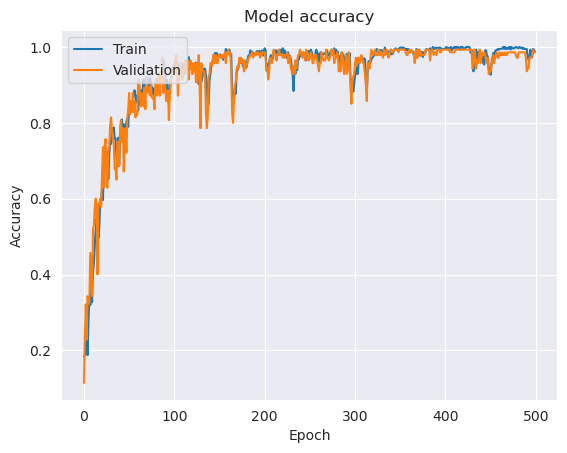

In [326]:
import matplotlib.pyplot as plt

plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [320]:
# Metrics
model.evaluate(X_train_reshaped, y_new_train)

18/18 [==============================] - 0s 9ms/step - loss: 1.6059 - accuracy: 0.2982


[1.6059263944625854, 0.29821428656578064]

In [321]:
# Show the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(X_train_reshaped)
y_pred = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_train, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

18/18 [==============================] - 1s 8ms/step


ValueError: Found input variables with inconsistent numbers of samples: [718, 560]

In [374]:
LABEL

{'Jump': 0, 'Kick': 1, 'Punch': 2, 'Left': 3, 'Right': 4, 'Stand': 5}